Tools  
[Write Midi Files](https://github.com/MarkCWirt/MIDIUtil)  
[Midi to CSV](https://pypi.org/project/py-midicsv/)  
[ABC Notation Player](https://github.com/mdoege/PySynth) 
[Midi to Wav](https://pypi.org/project/midi2audio/)  
[Mido <-> ABC in C](https://github.com/leesavide/abcmidi)  
[General Midi Instruments](https://en.wikipedia.org/wiki/General_MIDI#Bass)  


Resources  
[Andrej C-RNN Blog](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)  
[Midi File Format Info](https://www.csie.ntu.edu.tw/~r92092/ref/midi/)  
[Audio Stype Transfer Using Autoencoder](https://arxiv.org/abs/1812.07159)  



Architectures  
[C-RNN](https://github.com/karpathy/char-rnn)
[Autoencoder Example](https://www.learnopencv.com/understanding-autoencoders-using-tensorflow-python/)  


Tutorials  
[Siraj Uses Magenta](https://www.youtube.com/watch?v=pg9apmwf7og)  
[Toward Data Science Article](https://towardsdatascience.com/how-to-generate-music-using-a-lstm-neural-network-in-keras-68786834d4c5)  

MIDI Library  
[Cprato](https://www.cprato.com)  
[Midi File Library](https://bitmidi.com)  

Notes  
CaryKH added Mozart to Bach, which doubles sample size. He then tranposed all data 6 times, one for each semitone. Then modifed Adnrej's network to 3 layers and 700 neurons each. Transposing the music up a half step makes it look like a new music (in pitch) to the network [Link](https://www.youtube.com/watch?v=SacogDL_4JU)




'commonkey.mid' - Melody, bass, and drum mapped to single 128 vectors

# Imports

In [9]:
# Tools
import os
import pandas as pd
import numpy as np
from collections import defaultdict
from tqdm.auto import trange
import glob
import pickle
import gc
#Visualization
import seaborn as sns
import matplotlib.pyplot as plt
# Music Related
import IPython.display as ipd
import pypianoroll
from music21 import converter, instrument, note, chord,stream
# Modeling
from keras.layers import LSTM,Dropout,Dense,TimeDistributed,Conv1D,MaxPooling1D,Flatten,GlobalAveragePooling1D,AveragePooling1D,GlobalMaxPooling1D,BatchNormalization,Activation,Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from keras_radam import RAdam
from sklearn.datasets import california_housing
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.preprocessing import MultiLabelBinarizer,LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split,RandomizedSearchCV, KFold,cross_val_score,StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from keras_radam import RAdam

# Play Midi Files

## Run this code of midi player doesn't work

In [4]:
# Run this code of midi player doesn't work

midi_file = 'data/midi/Alan Walker - Alone  (midi by Carlo Prato) (www.cprato.com).mid'
freq = 44100    # audio CD quality
bitsize = -16   # unsigned 16 bit
channels = 2    # 1 is mono, 2 is stereo
buffer = 1024    # number of samples
pygame.mixer.init(freq, bitsize, channels, buffer)

# optional volume 0 to 1.0
pygame.mixer.music.set_volume(0.8)
try:
    play_music(midi_file)
except KeyboardInterrupt:
    # if user hits Ctrl/C then exit
    # (works only in console mode)
    pygame.mixer.music.fadeout(1000)
    pygame.mixer.music.stop()
    raise SystemExit

Music file data/midi/Alan Walker - Alone  (midi by Carlo Prato) (www.cprato.com).mid loaded!


SystemExit: 

/Users/matthewlee/anaconda3/envs/nlp/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Midi <-> Pianoroll - Adjusted (Center Notes)

In [12]:
import py_midicsv
import os

# Load file names
filenames = os.listdir('data/midi')
if '.DS_Store' in filenames:
    filenames.remove('.DS_Store')

filenames_clean = filenames.copy()
# Remove Unnecessary Strings
for ix,file in enumerate(filenames_clean):
    filenames_clean[ix] = filenames_clean[ix].replace('  (midi by Carlo Prato) (www.cprato.com)','')
    filenames_clean[ix] = filenames_clean[ix].replace(' (midi by Carlo Prato) (www.cprato.com)','')

# Generate Pandas Dataframe with filenames and CSV version of MIDI files
csvs = []
music_type = []
for filename in filenames:
    csvs.append(py_midicsv.midi_to_csv('data/midi/'+filename))
df_edm = pd.DataFrame({'filenames':filenames,'filenames_clean':filenames_clean,'csvs':csvs})
df_edm['filenames_clean2'] = df_edm['filenames_clean'].copy()
df_edm['filenames_clean2'] = df_edm['filenames_clean2'].apply(lambda x:x.upper())
df_edm.sort_values(by=['filenames_clean2'],inplace=True)
df_edm.drop(columns=['filenames_clean2'],inplace=True)
df_edm.reset_index(drop=True,inplace=True)

In [1210]:
#!pip install pypianoroll
import pypianoroll

# Instrument names for look up
melody_name = ['Bassmelody','Chords','Lead','MIDI Out','Pad','Piano','Saw Chords','Second Lead','Strings',
'Voice','Voice Synth']
bass_name = ['Basses','basses','Bass','bass']
drum_name = ['Drums','drums','Drum','drum']

# Merge all tracks and Combine all songs
#melody,bass,drum = [[0]*128],[[0]*128],[[0]*128]
melody,bass,drum = [],[],[]

for ix,song in enumerate(df_edm['filenames'][:]): # Switch multiple songs
#for ix,song in enumerate([df_edm['filenames'].iloc[18]]): # Play a single song
    midi_loaded = pypianoroll.Multitrack('data/midi/'+song)
    
    melody_holder = np.zeros(midi_loaded.tracks[0].pianoroll.shape)
    bass_holder   = np.zeros(midi_loaded.tracks[0].pianoroll.shape)
    drum_holder   = np.zeros(midi_loaded.tracks[0].pianoroll.shape)

    for jx,track in enumerate(midi_loaded.tracks):
        if track.name in bass_name:
            bass_holder+=track.pianoroll
        elif track.name in drum_name:
            drum_holder+=track.pianoroll    
        else:
            melody_holder+=track.pianoroll
    melody.append(melody_holder[:-120])
    bass.append(bass_holder[:-120])
    drum.append(drum_holder[:-120])

# Let first song's mean note to be note to adjust other songs to. For melody and bass only.
melody_keyss = []
for seq in melody[0]:
    melody_keyss += [ ix for (ix,x) in enumerate(seq) if x >= 10 ]
mean_note = int(np.mean(melody_keyss))

# Adjust rest of song's keys to be centered around first song's mean key. For melody and bass only.
for ix,song in enumerate(melody):
    melody_keyss = []
    for seq in song:
        melody_keyss += [ ix for (ix,x) in enumerate(seq) if x >= 10 ]
    current_song_mean_note = int(np.mean(melody_keyss))   
    melody[ix] = np.roll(melody[ix],mean_note-current_song_mean_note)
    bass[ix] = np.roll(bass[ix],mean_note-current_song_mean_note)
    
# Concat all individual files
melody_compiled,bass_compiled,drum_compiled = melody[0],bass[0],drum[0]
for i in trange(1,len(melody)):
    melody_compiled = np.concatenate((melody_compiled,melody[i][2:]))
    bass_compiled = np.concatenate((bass_compiled,bass[i][2:]))
    drum_compiled = np.concatenate((drum_compiled,drum[i][2:]))

# Update blank midi file with compiled version
blank_midi = pypianoroll.Multitrack('midi/blank.mid')
blank_midi.tempo = midi_loaded.tempo/midi_loaded.tempo*120


blank_midi.tracks[0].pianoroll = melody_compiled
blank_midi.tracks[1].pianoroll = bass_compiled
blank_midi.tracks[2].pianoroll = drum_compiled

# Save to midi file and play
pypianoroll.write(blank_midi,'midi/compiled_adj_with_classic.mid')
#play_music("compiled.mid")

# 12 Semitones

In [1211]:
# Create compiled midi's all 6 semitones. Trying 12 semitones with long classic music didnt work...
blank_midi = pypianoroll.Multitrack('midi/compiled_adj_with_classic.mid')
blank_midi.tempo = midi_loaded.tempo/midi_loaded.tempo*120
semitone = blank_midi.tracks[0].pianoroll
semitone_compiled = blank_midi.tracks[0].pianoroll
semitone_list = [-3,-2,-1,1,2,3]
for i in trange(len(semitone_list)):
    semitone_compiled = np.concatenate((semitone_compiled,np.roll(semitone,semitone_list[i])))
blank_midi.tracks[0].pianoroll = semitone_compiled
blank_midi.tracks.pop(1)
blank_midi.tracks.pop(1)
pypianoroll.write(blank_midi,'midi/semitone_adj_with_classic.mid')
#play_music("semitone.mid")

In [5]:
# Create compiled midi's all 12 semitones. Then only take melody and save to semitone_adj.mid
blank_midi = pypianoroll.Multitrack('midi/compiled_adjusted.mid')
blank_midi.tempo = midi_loaded.tempo/midi_loaded.tempo*120
semitone = blank_midi.tracks[0].pianoroll
semitone_compiled = blank_midi.tracks[0].pianoroll
semitone_list = [-6,-5,-4,-3,-2,-1,1,2,3,4,5,6]
for i in trange(len(semitone_list)):
    semitone_compiled = np.concatenate((semitone_compiled,np.roll(semitone,semitone_list[i])))
blank_midi.tracks[0].pianoroll = semitone_compiled
blank_midi.tracks.pop(1)
blank_midi.tracks.pop(1)
pypianoroll.write(blank_midi,'midi/semitone_adj.mid')
#play_music("semitone.mid")

# Same as above but for bass
blank_midi = pypianoroll.Multitrack('midi/compiled_adjusted.mid')
blank_midi.tempo = blank_midi.tempo/blank_midi.tempo*120
semitone = blank_midi.tracks[1].pianoroll
semitone_compiled = blank_midi.tracks[1].pianoroll
semitone_list = [-6,-5,-4,-3,-2,-1,1,2,3,4,5,6]
for i in trange(len(semitone_list)):
    semitone_compiled = np.concatenate((semitone_compiled,np.roll(semitone,semitone_list[i])))
blank_midi.tracks[1].pianoroll = semitone_compiled
blank_midi.tracks.pop(0)
blank_midi.tracks.pop(1)
pypianoroll.write(blank_midi,'midi/semitone_adj_bass.mid')

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 53.26it/s]


In [146]:
# Drum is just drum. No semition.
blank_midi = pypianoroll.Multitrack('midi/compiled_adjusted.mid')
blank_midi.tempo = blank_midi.tempo/blank_midi.tempo*120
blank_midi.tracks.pop(0)
blank_midi.tracks.pop(0)
pypianoroll.write(blank_midi,'midi/adj_drum.mid')
play_music("midi/adj_drum.mid")

Music file midi/adj_drum.mid loaded!


SystemExit: 

# Follow Medium Article

In [244]:
# #!pip install music21
from music21 import converter, instrument, note, chord,stream

# Melody Portion
notes = []
for file in glob.glob("commonkey.mid"):
    midi = converter.parse(file)
    notes_to_parse = None
    parts = instrument.partitionByInstrument(midi)
    if parts: # file has instrument parts
        notes_to_parse = parts.parts[0].recurse()
    else: # file has notes in a flat structure
        notes_to_parse = midi.flat.notes
    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            notes.append('.'.join(str(n) for n in element.normalOrder))
pickle.dump( notes, open( "commonkey.pkl", "wb" ) )

# notes = pickle.load( open( "notes_just_adj.pkl", "rb" ) )
notes = pickle.load( open( "notes.pkl", "rb" ) )
# notes = pickle.load( open( "commonkey.pkl", "rb" ) )



# Modeling

## Train

In [153]:
# Just Melody

sequence_length = 100
n_vocab = len(list(set(notes)))
# get all pitch names
pitchnames = sorted(set(item for item in notes))
# create a dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
network_input = []
network_output = []
# create input sequences and the corresponding outputs
for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])
n_patterns = len(network_input)
# reshape the input into a format compatible with LSTM layers
network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
# normalize input
network_input = network_input / float(n_vocab)
network_output = to_categorical(network_output)

In [154]:
# baseline
model = Sequential()
model.add(LSTM(
    256,
    input_shape=(network_input.shape[1], network_input.shape[2]),
    return_sequences=True
))
model.add(Dropout(0.3))
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(n_vocab))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [155]:
filepath = "weights_drum/100_notes_drum{epoch:02d}-{loss:.4f}-bigger.hdf5"    
checkpoint = ModelCheckpoint(
    filepath, monitor='loss', 
    verbose=0,        
    save_best_only=True,        
    mode='min'
)    
callbacks_list = [checkpoint]     
model.fit(network_input, network_output, epochs=4000, batch_size=128, callbacks=callbacks_list)

Instructions for updating:
Use tf.cast instead.
Epoch 1/4000
 384/3159 [==>...........................] - ETA: 4:24 - loss: 3.2263

KeyboardInterrupt: 

## Load Weight and Generate Melody

As you can see, a low temperature results in extremely repetitive and predictable text, but where local structure is highly realistic: in particular, all words (a word being a local pattern of characters) are real English words. With higher temperatures, the generated text becomes more interesting, surprising, even creative; it may sometimes invent completely new words that sound somewhat plausible (such as "eterned" or "troveration"). With a high temperature, the local structure starts breaking down and most words look like semi-random strings of characters. [Link](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/8.1-text-generation-with-lstm.ipynb)

## Functions to load necessary files and models

In [79]:
# Don't always choose the most likely prediction
def sample(preds, temperature):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

## Load and predict Melody

#### 12 Semitones

In [120]:
from music21 import converter, instrument, note, chord,stream
#model_weight = 'weights/3-notes-adj-semitone-more-neurons3846-0.6399-bigger.hdf5
#notes = pickle.load( open( "notes.pkl", "rb" ) )

# #Classic no semi
# model_weight = 'weights/weight_3_steps_adj_classic_more_neuron15925-0.4948-bigger.hdf5' 
# notes = pickle.load( open( 'notes_just_adj_classic_no_semitone.pkl', "rb" ) )

#Classic 6 semi
model_weight = 'weights/classic_3steps_6semitone_adj2065-1.1360-bigger.hdf5' 
notes = pickle.load( open( "notes_semitone_6_classic.pkl", "rb" ) )

sequence_length = 3
n_vocab = len(list(set(notes)))
# get all pitch names
pitchnames = sorted(set(item for item in notes))
# create a dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
network_input = []
network_output = []
# create input sequences and the corresponding outputs
for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])
n_patterns = len(network_input)
# reshape the input into a format compatible with LSTM layers
network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
# normalize input
network_input = network_input / float(n_vocab)
network_output = to_categorical(network_output)

# 12 semitone
model = Sequential()
model.add(LSTM(
    512,
    input_shape=(network_input.shape[1], network_input.shape[2]),
    return_sequences=True
))
model.add(Dropout(0.3))
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(512))
model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(n_vocab))
model.add(Activation('softmax'))
model.compile(RAdam(),loss='categorical_crossentropy')

# Load the weights
model.load_weights(model_weight)

In [127]:
# Generate new song
start = np.random.randint(0, len(network_input)-1)
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
pattern = list(network_input[start])
prediction_output = []

# generate 300 notes
#temperatures = np.arange(1.1,1.4,0.1) #Worked well with 3 ntoes np.arange(1,1.3,0.1)
#temperatures = np.arange(1.3,1.8,0.1)  #worked well with 7 notes
#temperatures = [0.9,1.1,1.3,1.8,2]
#temperatures = [x-0.07  for x in temperatures]
temperatures = [1.4]
for note_index in trange(300):
    prediction_input = np.reshape(pattern, (1, len(pattern), 1))
    prediction_input = prediction_input / float(n_vocab)
    prediction = model.predict(prediction_input, verbose=0)
    #index = np.argmax(prediction)
    #temperature = np.random.choice(temperatures,p=[0.7,0.15,0.1,0.04,0.01])
    index = sample(prediction[0],temperatures)
    result = int_to_note[index]
    prediction_output.append(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]

offset = 0
output_notes = []
# create note and chord objects based on the values generated by the model
for pattern in prediction_output:
    # pattern is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # pattern is a note
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)
    # increase offset each iteration so that notes do not stack
    offsets = [0.4,0.8]
    offset += np.random.choice(offsets,p=[0.96,0.04])
# Save midi file
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='midi/melody_output.mid')

'midi/melody_output.mid'

In [129]:
# 108, 114?, 1, 4, 8, 11, 12, 38!, 46, 53(interesting), 62, 71,80,81, 82
# Play the song for semitone
test_midi = pypianoroll.Multitrack('midi/melody_output.mid')
test_midi.tracks[0].pianoroll =  test_midi.tracks[0].pianoroll[:500]#600]#-100]
test_midi.tracks[0].program=0
pypianoroll.write(test_midi,'midi/test_output.mid')
play_music('midi/test_output.mid')

Music file midi/test_output.mid loaded!


In [119]:
play_music('midi/success3.mid')

Music file midi/success3.mid loaded!


SystemExit: 

/Users/matthewlee/anaconda3/envs/nlp/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


/Users/matthewlee/anaconda3/envs/nlp/lib/python3.6/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


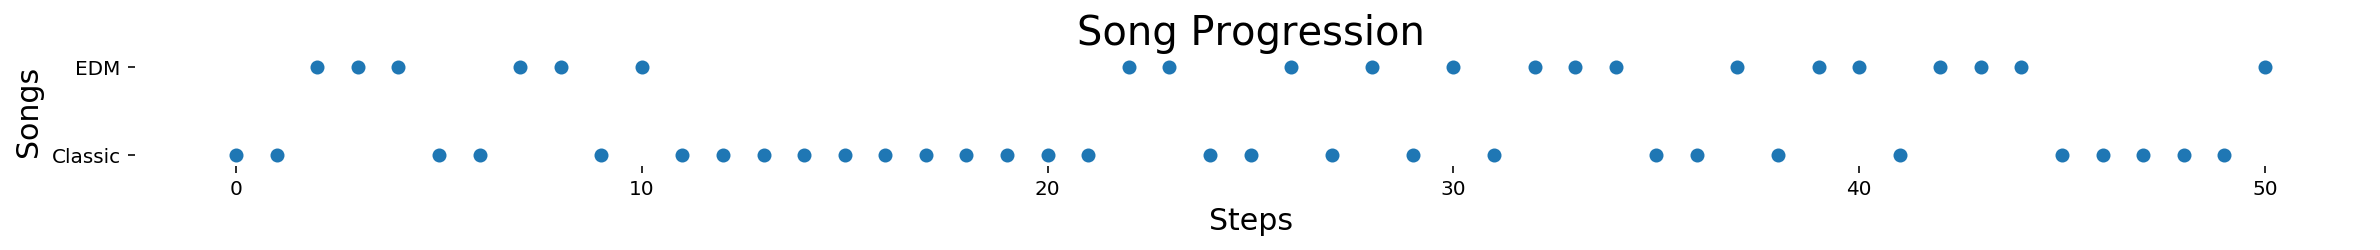

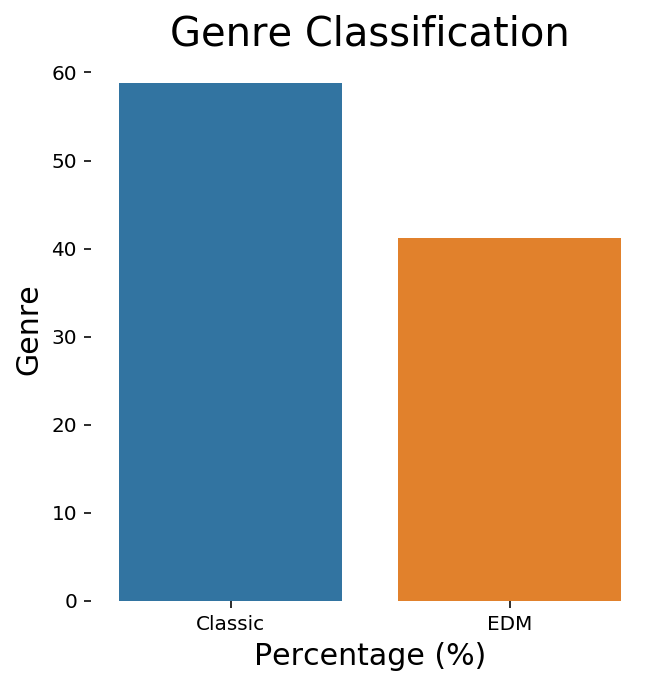

In [132]:
filename = 'midi/test_output.mid'
#filename = 'data/midi/'+df_edm['filenames'][0]
#filename = 'data/midi_classic/'+df_classic['filenames'][9]
# Take out drum and only leave melody
blank_midi =  pypianoroll.Multitrack('midi/blank.mid')
test_midi =  pypianoroll.Multitrack(filename)
blank_midi.tracks[0].pianoroll = test_midi.tracks[0].pianoroll
blank_midi.tracks.pop(1)
blank_midi.tracks.pop(1)
pypianoroll.write(blank_midi,'midi/classify.mid')
# Melody Portion
notes_classify = []
for file in glob.glob('midi/classify.mid'):
    midi = converter.parse(file)
    notes_to_parse = None
    parts = instrument.partitionByInstrument(midi)
    if parts: # file has instrument parts
        notes_to_parse = parts.parts[0].recurse()
    else: # file has notes_classify in a flat structure
        notes_to_parse = midi.flat.notes_classify
    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes_classify.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            notes_classify.append('.'.join(str(n) for n in element.normalOrder))
# Convert notes to int
ints_classify = []
for i in range(len(notes_classify)):
    ints_classify.append(note_to_int[notes_classify[i]])
# Prepare input data for model training
X = []
for i in range(len(ints_classify)-sequence_length):
    X.append(ints_classify[i:i+sequence_length])
pred = classify_model.predict(scaler.transform(X))
pred_label = []
for label in pred:
    pred_label+=list(label)
pred_label = ['EDM' if x>0.4 else 'Classic' for x in pred_label]
plot_genre_progression(pred_label)
plot_genre_composition(pred_label)

In [131]:
# Load saved notes for both EDM and Classic
notes_edm = pickle.load( open( "midi/classifier/notes_edm.pkl", "rb" ) )
notes_classic = pickle.load( open( "midi/classifier/notes_classic.pkl", "rb" ) )
notes_combined = notes_edm+notes_classic
# Convert notes to int
n_vocab = len(list(set(notes_combined)))
# get all pitch names
pitchnames = sorted(set(item for item in notes_combined))
# create a dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
# Convert notes to int
ints_edm = []
for i in range(len(notes_edm)):
    ints_edm.append(note_to_int[notes_edm[i]])
ints_classic = []
for i in range(len(notes_classic)):
    ints_classic.append(note_to_int[notes_classic[i]])
# Prepare input data for model training
X = []
y = []
sequence_length = 10
for i in range(len(ints_edm)-sequence_length):
    X.append(ints_edm[i:i+sequence_length])
    y.append('EDM')
for i in range(len(ints_classic)-sequence_length):
    X.append(ints_classic[i:i+sequence_length])
    y.append('Classic')  
X = np.array(X)
y = np.array(y)
# create scaler
scaler = StandardScaler()
# fit scaler on data
scaler.fit(X)
# apply transform
X_std = scaler.transform(X)

encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
# create model
classify_model = Sequential()
classify_model.add(Dense(32, input_dim=X.shape[1], activation='relu'))
classify_model.add(Dense(16,  activation='relu'))
classify_model.add(Dense(1, activation='sigmoid'))
# Compile model
classify_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# # Train
#model.fit(X_std, encoded_y, epochs=4000, batch_size=1024, verbose=2)
classify_model = pickle.load( open('nn_classifier.pkl', "rb" ) )

#### Just Adj

In [14]:
model_weight = 'weights/weight_3_steps_adj_classic_more_neuron15925-0.4948-bigger.hdf5'

notes = pickle.load( open( "notes_just_adj_classic_no_semitone.pkl", "rb" ) )
sequence_length = 3
n_vocab = len(list(set(notes)))
# get all pitch names
pitchnames = sorted(set(item for item in notes))
# create a dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
network_input = []
network_output = []
# create input sequences and the corresponding outputs
for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])
n_patterns = len(network_input)
# reshape the input into a format compatible with LSTM layers
network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
# normalize input
network_input = network_input / float(n_vocab)
network_output = to_categorical(network_output)

# Melody + Bass + Drum
model = Sequential()
model.add(LSTM(
    512,
    input_shape=(network_input.shape[1], network_input.shape[2]),
    return_sequences=True
))
model.add(Dropout(0.3))
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(512))
model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(n_vocab))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

# Load the weights
model.load_weights(model_weight)

OSError: Unable to open file (unable to open file: name = 'weights/weight_3_steps_adj_classic_more_neuron15925-0.4948-bigger.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [37]:
# Generate new song
start = np.random.randint(0, len(network_input)-1)
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
pattern = list(network_input[start])
prediction_output = []

# generate 300 notes
#temperatures = np.arange(1.1,1.2,0.01) #Worked well with 3 ntoes np.arange(1,1.3,0.1)
#temperatures = np.arange(1.3,1.8,0.1)  #worked well with 7 notes
temperatures = [0.9,1.1,1.3,1.8,2]
temperatures = [x+0.7 for x in temperatures]
    
for note_index in trange(800):
    prediction_input = np.reshape(pattern, (1, len(pattern), 1))
    prediction_input = prediction_input / float(n_vocab)
    prediction = model.predict(prediction_input, verbose=0)
    #index = np.argmax(prediction)
    temperature = np.random.choice(temperatures,p=[0.7,0.15,0.1,0.04,0.01])    
    index = sample(prediction[0],temperature)
    result = int_to_note[index]
    prediction_output.append(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]

offset = 0
output_notes = []
# create note and chord objects based on the values generated by the model
for pattern in prediction_output:
    # pattern is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # pattern is a note
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)
    # increase offset each iteration so that notes do not stack
    offsets = [0.4,0.8]
    offset += np.random.choice(offsets,p=[0.98,0.02])
# Save midi file
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='midi/melody_output.mid')

'midi/melody_output.mid'

In [38]:
# Play the song for semitone
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='midi/melody_output.mid')
test_midi = pypianoroll.Multitrack('midi/melody_output.mid')
test_midi.tracks[0].pianoroll =  test_midi.tracks[0].pianoroll[:] 
test_midi.tracks[0].program=1
pypianoroll.write(test_midi,'midi/melody_output.mid')
play_music('midi/melody_output.mid')
# play_music('compiled.mid')

Music file midi/melody_output.mid loaded!


#### Common Keys

In [1233]:
model_weight = '100_steps_just_adj_commonkey73-0.0194-bigger.hdf5'

notes = pickle.load( open( "commonkey.pkl", "rb" ) )
sequence_length = 100
n_vocab = len(list(set(notes)))
# get all pitch names
pitchnames = sorted(set(item for item in notes))
# create a dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
network_input = []
network_output = []
# create input sequences and the corresponding outputs
for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])
n_patterns = len(network_input)
# reshape the input into a format compatible with LSTM layers
network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
# normalize input
network_input = network_input / float(n_vocab)
network_output = to_categorical(network_output)

# Melody + Bass + Drum
model = Sequential()
model.add(LSTM(
    256,
    input_shape=(network_input.shape[1], network_input.shape[2]),
    return_sequences=True
))
model.add(Dropout(0.3))
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(n_vocab))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

# Load the weights
model.load_weights(model_weight)

In [1234]:
# Generate new song
start = np.random.randint(0, len(network_input)-1)
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
pattern = list(network_input[start])
prediction_output = []
# generate 300 notes
#temperatures = np.arange(0.1,1,0.1)
temperatures = [0.2]
for note_index in trange(50):
    prediction_input = np.reshape(pattern, (1, len(pattern), 1))
    prediction_input = prediction_input / float(n_vocab)
    prediction = model.predict(prediction_input, verbose=0)
    #index = np.argmax(prediction)
    index = sample(prediction[0],np.random.choice(temperatures))
    result = int_to_note[index]
    prediction_output.append(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]



/Users/matthewlee/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


In [212]:
offset = 0
output_notes = []
# create note and chord objects based on the values generated by the model
for pattern in prediction_output:
    # pattern is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # pattern is a note
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)
    # increase offset each iteration so that notes do not stack
    offset += 0.4

# Play the song for all instruments
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='midi/test_output.mid')

test_midi = pypianoroll.Multitrack('midi/test_output.mid')
commonkey_compiled = test_midi.tracks[0].pianoroll

# Reverse commonkey vector into melody, bass, and 
commonkey_compiled_keys = []
for seq in commonkey_compiled:
    seq_keys = []
    seq_keys = [ ix for (ix,x) in enumerate(seq) if x >= 10 ]
    if len(seq_keys)==0:
        seq_keys = []
    commonkey_compiled_keys.append(seq_keys)

# Generate reversed vectors for midi file generation
melody_compiled_reversed = []
bass_compiled_reversed = []
drum_compiled_reversed = []
for i in trange(len(commonkey_compiled_keys)):
    empty_seq_melody = np.array([0]*128)
    empty_seq_bass = np.array([0]*128)
    empty_seq_drum = np.array([0]*128)
    for j in range(len(commonkey_compiled_keys[i])):        
        if commonkey_compiled_keys[i][j] in commonkey_to_melodykey.keys():
            empty_seq_melody[commonkey_to_melodykey[commonkey_compiled_keys[i][j]]]=100
        elif commonkey_compiled_keys[i][j] in commonkey_to_basskey.keys():
            empty_seq_bass[commonkey_to_basskey[commonkey_compiled_keys[i][j]]]=100
        elif commonkey_compiled_keys[i][j] in commonkey_to_drumkey.keys():
            empty_seq_drum[commonkey_to_drumkey[commonkey_compiled_keys[i][j]]]=100
    melody_compiled_reversed.append(empty_seq_melody)
    bass_compiled_reversed.append(empty_seq_bass)
    drum_compiled_reversed.append(empty_seq_drum) 




  0%|          | 0/408 [00:00<?, ?it/s]


100%|██████████| 408/408 [00:00<00:00, 10947.12it/s]

In [183]:
melody_compiled_reversed = np.array(melody_compiled_reversed)
bass_compiled_reversed = np.array(bass_compiled_reversed)
drum_compiled_reversed = np.array(drum_compiled_reversed)

# Update blank midi file with compiled version
blank_midi = pypianoroll.Multitrack('midi/blank.mid')
blank_midi.tempo = midi_loaded.tempo/midi_loaded.tempo*120
blank_midi.tracks[0].program=81

blank_midi.tracks[0].pianoroll = melody_compiled_reversed
blank_midi.tracks[1].pianoroll = bass_compiled_reversed
blank_midi.tracks[2].pianoroll = drum_compiled_reversed

# # Only base
# blank_midi.tracks.pop(0)
# blank_midi.tracks.pop(1)

# Only drum
# blank_midi.tracks.pop(0)
# blank_midi.tracks.pop(0)

# Save to midi file and play
pypianoroll.write(blank_midi,'midi/test_output.mid')
play_music("midi/test_output.mid")

Music file midi/test_output.mid loaded!


In [177]:
blank_midi = pypianoroll.Multitrack('commonkey.mid')

In [183]:
blank_midi.tracks[0].pianoroll[2]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
       100,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0, 100,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=uint8)

## Load and predict Drum

In [661]:
from music21 import converter, instrument, note, chord,stream
model_weight = 'weights_drum/15_notes_drum2884-0.0759-bigger.hdf5'

notes_drum = pickle.load( open( "drum.pkl", "rb" ) )

sequence_length = 15
n_vocab = len(list(set(notes_drum)))
# get all pitch names
pitchnames = sorted(set(item for item in notes_drum))
# create a dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
network_input = []
network_output = []
# create input sequences and the corresponding outputs
for i in range(0, len(notes_drum) - sequence_length, 1):
    sequence_in = notes_drum[i:i + sequence_length]
    sequence_out = notes_drum[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])
n_patterns = len(network_input)
# reshape the input into a format compatible with LSTM layers
network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
# normalize input
network_input = network_input / float(n_vocab)
network_output = to_categorical(network_output)

# 12 semitone
model = Sequential()
model.add(LSTM(
    256,
    input_shape=(network_input.shape[1], network_input.shape[2]),
    return_sequences=True
))
model.add(Dropout(0.3))
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(n_vocab))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Load the weights
model.load_weights(model_weight)

In [662]:
# Generate new song
start = np.random.randint(0, len(network_input)-1)
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
pattern = list(network_input[start])
prediction_output = []
# generate 300 notes
temperatures = [0.4,0.8,1.1,1.5,2]
for note_index in trange(600):
    prediction_input = np.reshape(pattern, (1, len(pattern), 1))
    prediction_input = prediction_input / float(n_vocab)
    prediction = model.predict(prediction_input, verbose=0)
    #index = np.argmax(prediction)
    index = sample(prediction[0],np.random.choice(temperatures,p=[0.6,0.15,0.11,0.09,0.05]))
    result = int_to_note[index]
    prediction_output.append(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]

/Users/matthewlee/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


In [683]:
offset = 0
output_notes = []
# create note and chord objects based on the values generated by the model
for pattern in prediction_output:
    # pattern is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.BassDrum()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # pattern is a note
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.BassDrum()
        output_notes.append(new_note)
    # increase offset each iteration so that notes do not stack
    offsets = [0.8,0.4]
    offset += np.random.choice(offsets,p=[0.7,0.3])
# Save midi file
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='midi/drum_output.mid')

'midi/drum_output.mid'

In [684]:
# Play the song for semitone
test_midi = pypianoroll.Multitrack('midi/drum_output.mid')
drum_midi = pypianoroll.Multitrack('midi/blank.mid')
drum_midi.tempo = drum_midi.tempo/drum_midi.tempo*120
drum_midi.tracks[2].pianoroll = np.roll(test_midi.tracks[0].pianoroll,0)
drum_midi.tracks.pop(0)
drum_midi.tracks.pop(0)

pypianoroll.write(drum_midi,'midi/drum_output.mid')
# play_music('midi/drum_output.mid')
# play_music('compiled.mid')

## Combine Melody & Drum & Bass (Todo) - 100 seq = 2.2 sec

In [137]:
# Play the song for semitone : 
melody_midi = pypianoroll.Multitrack('midi/test_output.mid')
drum_midi = pypianoroll.Multitrack('midi/drum_output.mid')

blank_midi =  pypianoroll.Multitrack('midi/blank.mid')
blank_midi.tempo = blank_midi.tempo/blank_midi.tempo*115

blank_midi.tracks[0].pianoroll = np.roll(melody_midi.tracks[0].pianoroll[:],0)
number = 38
print(number)
blank_midi.tracks[0].program = number
#blank_midi.tracks[1].pianoroll =  #Bass
blank_midi.tracks[2].pianoroll = drum_midi.tracks[0].pianoroll[:len(blank_midi.tracks[0].pianoroll)]*1 #Cap drum length to melody's

blank_midi.tracks.pop(1) #Pop bass for now

pypianoroll.write(blank_midi,'midi/test.mid')
play_music('midi/test.mid')


38
Music file midi/test.mid loaded!


#### Successes

good programs : 108, 114?, 1, 4, 8, 11, 12, 38!, 46, 53(interesting), 62, 71,80,81, 82

In [120]:
# Sucess 1. Variation of Original. 3 Notes
blank_midi =  pypianoroll.Multitrack('midi/success1.mid')
blank_midi.tracks[0].pianoroll = blank_midi.tracks[0].pianoroll[110:500]
blank_midi.tracks[1].pianoroll = blank_midi.tracks[1].pianoroll[110:500]
blank_midi.tracks[0].program = 80
pypianoroll.write(blank_midi,'midi/test.mid')
play_music('midi/test.mid') 
#play_music('data/midi/'+df_edm['filenames'][8]) - Marshmello-Alone

Music file midi/test.mid loaded!


In [368]:
# Sucess 2. Kinda like Medly.
# '3-notes-adj-semitone-more-neurons3846-0.6399-bigger.hdf5' and np.arange(1,1.3,0.1)
blank_midi =  pypianoroll.Multitrack('midi/success2.mid')
blank_midi.tracks[0].pianoroll = blank_midi.tracks[0].pianoroll[250:900]
blank_midi.tracks[1].pianoroll = blank_midi.tracks[1].pianoroll[250:900]
blank_midi.tracks[0].program = 53
pypianoroll.write(blank_midi,'midi/test.mid')
play_music('midi/test.mid') 
#play_music('data/midi/'+df_edm['filenames'][13]) - Marshmello-Alone

Music file midi/test.mid loaded!


SystemExit: 

C:\Users\matt\Anaconda3\envs\nlp\lib\site-packages\IPython\core\interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [99]:
# Sucess 3. MY FAVORITE, I LOVE IT@! 절묘한 mix of many songs. Can't really pinpoint any song. 
# '3-notes-adj-semitone-more-neurons3846-0.6399-bigger.hdf5' 
# temperatures = [0.8,1,1.5,2]
# temperature = np.random.choice(temperatures,p=[0.7,0.1,0.1,0.1])
blank_midi =  pypianoroll.Multitrack('midi/success3.mid')
blank_midi.tracks[0].pianoroll = blank_midi.tracks[0].pianoroll
blank_midi.tracks[1].pianoroll = blank_midi.tracks[1].pianoroll
blank_midi.tracks[0].program = 81
pypianoroll.write(blank_midi,'midi/test.mid')
play_music('midi/test.mid') 
#play_music('data/midi/'+df_edm['filenames'][13]) - Marshmello-Alone

Music file midi/test.mid loaded!


SystemExit: 

In [106]:
# Sucess 4
blank_midi =  pypianoroll.Multitrack('midi/success4.mid')
blank_midi.tracks[0].pianoroll = blank_midi.tracks[0].pianoroll
blank_midi.tracks[1].pianoroll = blank_midi.tracks[1].pianoroll
blank_midi.tracks[0].program = 81
pypianoroll.write(blank_midi,'midi/test.mid')
play_music('midi/test.mid') 
#play_music('data/midi/'+df_edm['filenames'][13]) - Marshmello-Alone

Music file midi/test.mid loaded!


In [104]:
# success1,success2,success3
lgbm_edm = pickle.load( open('lgbm_just_edm_12semitone.pkl', "rb" ) )
blank_midi =  pypianoroll.Multitrack('midi/test.mid')
test_data = pd.DataFrame(blank_midi.tracks[0].pianoroll)
test_data = test_data.rolling(50).sum()
test_data.dropna(inplace=True)
pred = lgbm_edm.predict(test_data.values)
plot_song_composition(pred)

FileNotFoundError: [Errno 2] No such file or directory: 'lgbm_just_edm_12semitone.pkl'

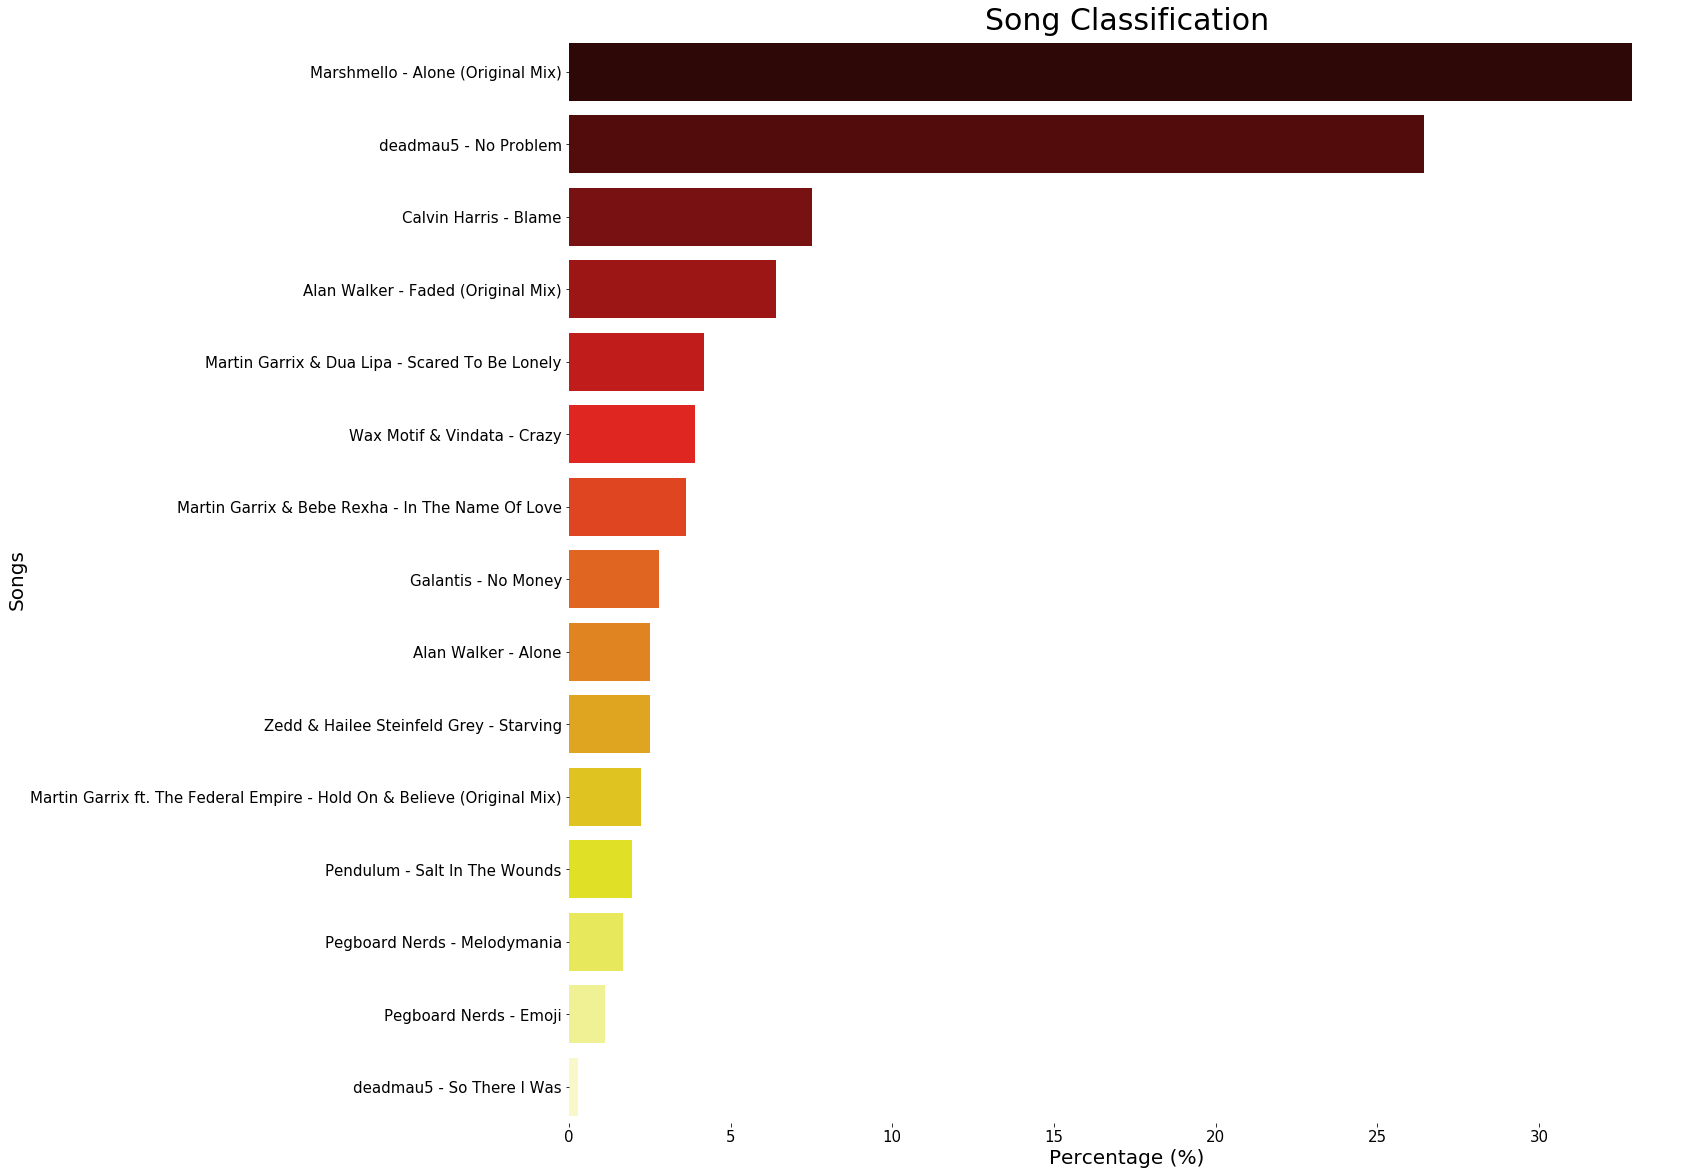

In [374]:
# success1,success2,success3
lgbm_edm = pickle.load( open('≈.pkl', "rb" ) )
blank_midi =  pypianoroll.Multitrack('midi/test.mid')
test_data = pd.DataFrame(blank_midi.tracks[0].pianoroll)
test_data = test_data.rolling(50).sum()
test_data.dropna(inplace=True)
pred = lgbm_edm.predict(test_data.values)
plot_song_composition(pred)

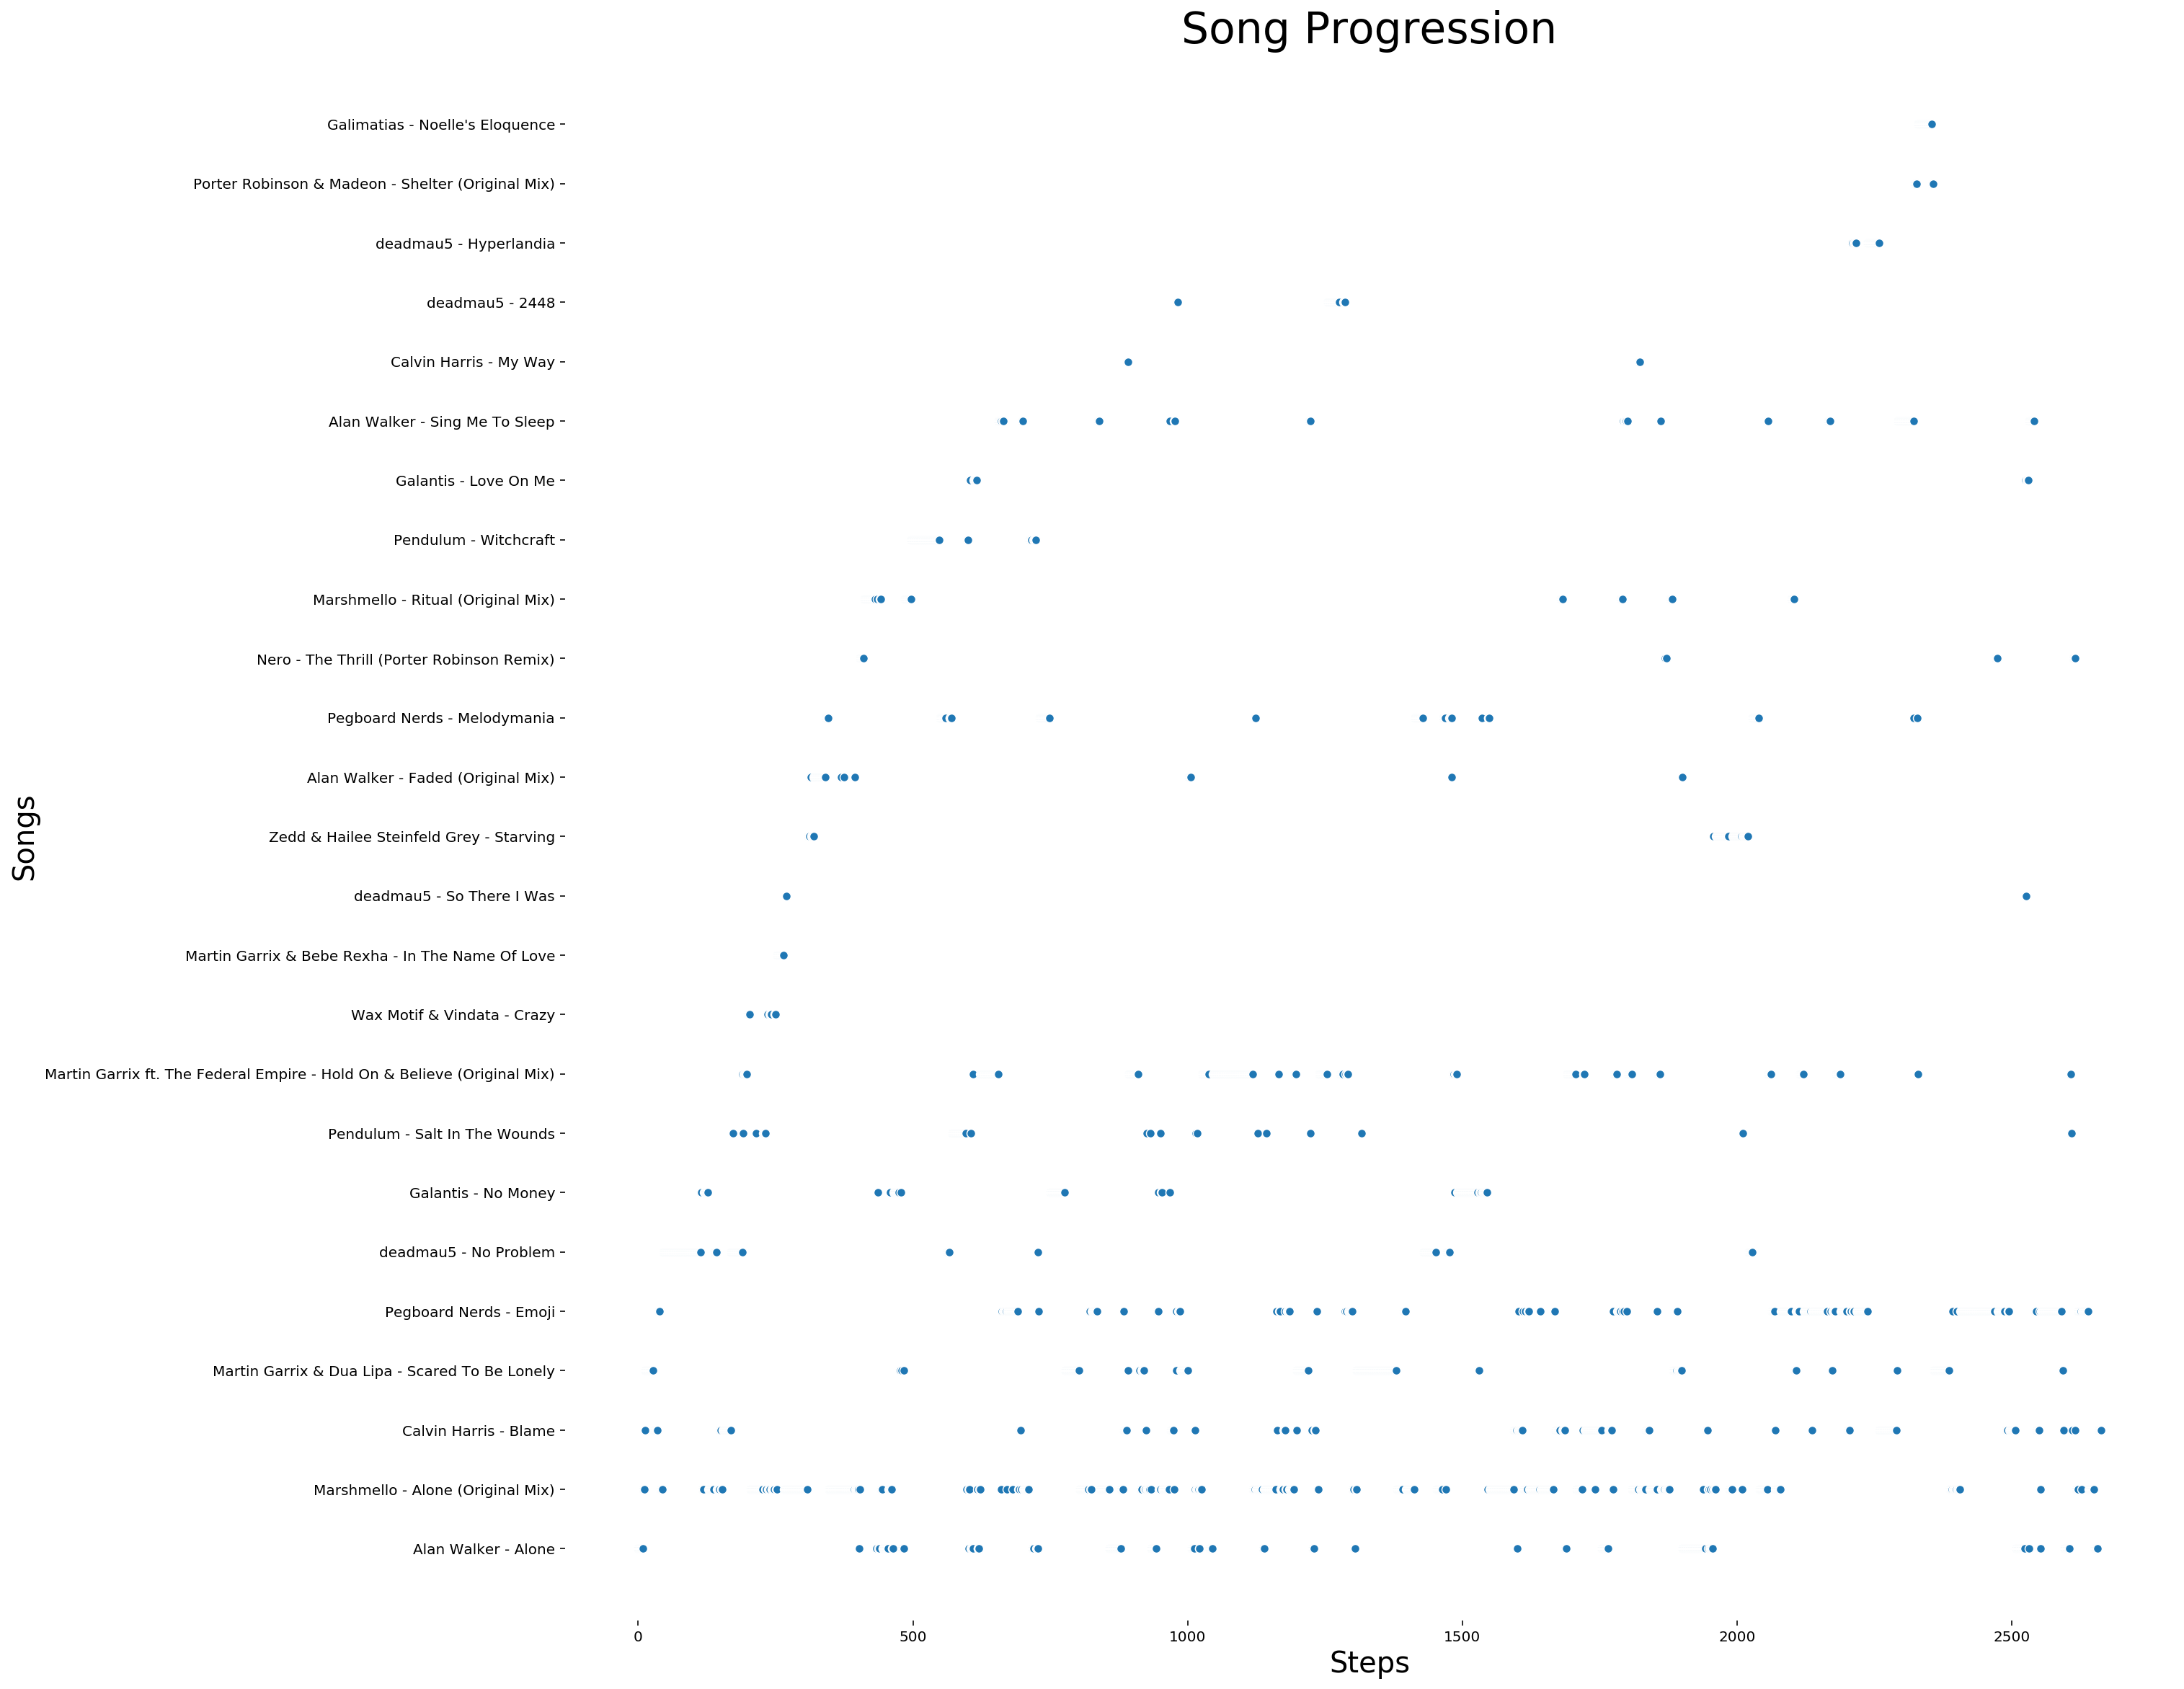

In [42]:
plot_song_progression(pred)

# Song Classifiction

## Prepare Dataframe

In [5]:
import py_midicsv
import os

# Load file names
edm_filenames = os.listdir('data/midi')
if '.DS_Store' in edm_filenames:
    edm_filenames.remove('.DS_Store')

edm_filenames_clean = edm_filenames.copy()
# Remove Unnecessary Strings
for ix,file in enumerate(edm_filenames_clean):
    edm_filenames_clean[ix] = edm_filenames_clean[ix].replace('  (midi by Carlo Prato) (www.cprato.com)','')
    edm_filenames_clean[ix] = edm_filenames_clean[ix].replace(' (midi by Carlo Prato) (www.cprato.com)','')

# Generate Pandas Dataframe with filenames and CSV version of MIDI files
music_type = []

df_edm = pd.DataFrame({'filenames':edm_filenames,'song':edm_filenames_clean})
df_edm['filenames_clean2'] = df_edm['song'].copy()
df_edm['music_type'] = df_edm['song'].copy()
df_edm['music_type'] = 'edm'
df_edm['filenames_clean2'] = df_edm['filenames_clean2'].apply(lambda x:x.upper())
df_edm.sort_values(by=['filenames_clean2'],inplace=True)
df_edm.drop(columns=['filenames_clean2'],inplace=True)
df_edm.reset_index(drop=True,inplace=True)

# Same as above but for classic
# Load file names
classic_filenames = os.listdir('data/midi_classic')
if '.DS_Store' in classic_filenames:
    classic_filenames.remove('.DS_Store')

classic_filenames_clean = classic_filenames.copy()
# Generate Pandas Dataframe with filenames and CSV version of MIDI files
music_type = []
df_classic = pd.DataFrame({'filenames':classic_filenames,'song':classic_filenames_clean})
df_classic['filenames_clean2'] = df_classic['song'].copy()
df_classic['music_type'] = df_classic['song'].copy()
df_classic['music_type'] = 'classic'
df_classic.sort_values(by=['filenames_clean2'],inplace=True)
df_classic.drop(columns=['filenames_clean2'],inplace=True)
df_classic.reset_index(drop=True,inplace=True)

## Classification Proof of Concept

### Train Classification Model

In [105]:
# Same as above but for classic
# Load file names
proof_filenames = os.listdir('data/midi_classification_proof')
if '.DS_Store' in proof_filenames:
    proof_filenames.remove('.DS_Store')

classic_filenames_clean = proof_filenames.copy()
# Generate Pandas Dataframe with filenames and CSV version of MIDI files
music_type = []
df_proof = pd.DataFrame({'filenames':proof_filenames,'song':classic_filenames_clean})
df_proof['filenames_clean2'] = df_proof['song'].copy()
df_proof['music_type'] = df_proof['song'].copy()
df_proof['music_type'] = 'classic'
df_proof['music_type'].loc[0]='edm'
df_proof.sort_values(by=['filenames_clean2'],inplace=True)
df_proof.drop(columns=['filenames_clean2'],inplace=True)
df_proof.reset_index(drop=True,inplace=True)

In [106]:
#!pip install pypianoroll
import pypianoroll

# Instrument names for look up
melody_name = ['Bassmelody','Chords','Lead','MIDI Out','Pad','Piano','Saw Chords','Second Lead','Strings',
'Voice','Voice Synth']
bass_name = ['Basses','basses','Bass','bass']
drum_name = ['Drums','drums','Drum','drum']

# Merge all tracks and Combine all songs
#melody,bass,drum = [[0]*128],[[0]*128],[[0]*128]
melody,bass,drum = [],[],[]
song_lengths = []
for ix,song in enumerate(df_proof['filenames'][:]): # Switch multiple songs
    midi_loaded = pypianoroll.Multitrack('data/midi_classification_proof/'+song)
    
    melody_holder = np.zeros((1500,128))
    bass_holder   = np.zeros((1500,128))
    drum_holder   = np.zeros((1500,128))

    for jx,track in enumerate(midi_loaded.tracks):
        if track.name in bass_name:
            bass_holder+=track.pianoroll[:1500]
        elif track.name in drum_name:
            drum_holder+=track.pianoroll[:1500] 
        else:
            melody_holder+=track.pianoroll[:1500]
    melody.append(melody_holder)
    bass.append(bass_holder)
    drum.append(drum_holder)
    song_lengths.append(len(melody_holder[1:]))
    
# # Let first song's mean note to be note to adjust other songs to. For melody and bass only.
# melody_keyss = []
# for seq in melody[0]:
#     melody_keyss += [ ix for (ix,x) in enumerate(seq) if x >= 10 ]
# mean_note = int(np.mean(melody_keyss))

# # Adjust rest of song's keys to be centered around first song's mean key. For melody and bass only.
# for ix,song in enumerate(melody):
#     melody_keyss = []
#     for seq in song:
#         melody_keyss += [ ix for (ix,x) in enumerate(seq) if x >= 10 ]
#     current_song_mean_note = int(np.mean(melody_keyss))   
#     melody[ix] = np.roll(melody[ix],mean_note-current_song_mean_note)
#     bass[ix] = np.roll(bass[ix],mean_note-current_song_mean_note)
    
# Concat all individual files
melody_compiled,bass_compiled,drum_compiled = melody[0],bass[0],drum[0]
for i in trange(1,len(melody)):
    melody_compiled = np.concatenate((melody_compiled,melody[i][2:]))
    bass_compiled = np.concatenate((bass_compiled,bass[i][2:]))
    drum_compiled = np.concatenate((drum_compiled,drum[i][2:]))

# Update blank midi file with compiled version
blank_midi = pypianoroll.Multitrack('midi/blank.mid')
blank_midi.tempo = midi_loaded.tempo/midi_loaded.tempo*120
blank_midi.tracks[0].pianoroll = melody_compiled
blank_midi.tracks.pop(1)
blank_midi.tracks.pop(1)

# semitone = blank_midi.tracks[0].pianoroll
# semitone_compiled = blank_midi.tracks[0].pianoroll
# semitone_list = [-3,-2,-1,1,2,3]
# for i in trange(len(semitone_list)):
#     semitone_compiled = np.concatenate((semitone_compiled,np.roll(semitone,semitone_list[i])))
# blank_midi.tracks[0].pianoroll = semitone_compiled
pypianoroll.write(blank_midi,'midi/classification_proof.mid')

In [107]:
#data = pd.DataFrame(semitone_compiled)
data = pd.DataFrame(melody_compiled)

target_names = []
edm_label = [0]
classic_label = [1]
target_names+=edm_label*song_lengths[0]
target_names+=classic_label*song_lengths[1]    

data['target']=data[127]
data['target']=target_names
#data['target']=target_names*7
# Create rolling sum of 50 sequences
data[np.arange(128)] = data[np.arange(128)].rolling(50).sum()
data.dropna(inplace=True)

In [108]:
X = data[np.arange(128)]
X.columns = list(X.columns)
y = data['target']

#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2)

gbm = xgb.XGBClassifier( 
                        n_estimators=150,
                        max_depth=4,
                        objective='binary:logistic', #new objective
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                       )

eval_set=[(X_train.values,y_train),(X_val.values,y_val)]
fit_model = gbm.fit( 
                    X_train.values, y_train, 
                    eval_set=eval_set,
                    eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

accuracy_score(y_test, gbm.predict(X_test.values, ntree_limit=gbm.best_ntree_limit)) 

### Train Neural Net and Create MIDI Files

In [110]:
# #!pip install music21
from music21 import converter, instrument, note, chord,stream

# Melody Portion
notes = []
for file in glob.glob('midi/classification_proof.mid'):
    midi = converter.parse(file)
    notes_to_parse = None
    parts = instrument.partitionByInstrument(midi)
    if parts: # file has instrument parts
        notes_to_parse = parts.parts[0].recurse()
    else: # file has notes in a flat structure
        notes_to_parse = midi.flat.notes
    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            notes.append('.'.join(str(n) for n in element.normalOrder))
pickle.dump( notes, open( "classification_proof.pkl", "wb" ) )
notes = pickle.load( open( "classification_proof.pkl", "rb" ) )


In [128]:
sequence_length = 3
n_vocab = len(list(set(notes)))
# get all pitch names
pitchnames = sorted(set(item for item in notes))
# create a dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
network_input = []
network_output = []
# create input sequences and the corresponding outputs
for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])
n_patterns = len(network_input)
# reshape the input into a format compatible with LSTM layers
network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
# normalize input
network_input = network_input / float(n_vocab)
network_output = to_categorical(network_output)

# Model Architecture
model = Sequential()
model.add(LSTM(
    256,
    input_shape=(network_input.shape[1], network_input.shape[2]),
    return_sequences=True
))
model.add(Dropout(0.3))
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(n_vocab))
model.add(Activation('softmax'))
model.compile(RAdam(),loss='categorical_crossentropy')

In [131]:
filepath = "weights_train/classification_proof-{epoch:02d}-{loss:.4f}-bigger.hdf5"    
checkpoint = ModelCheckpoint(
    filepath, monitor='loss', 
    verbose=0,        
    save_best_only=True,        
    mode='min'
)    
callbacks_list = [checkpoint]     
model.fit(network_input, network_output, epochs=4000, batch_size=1024, callbacks=callbacks_list)

Epoch 1/4000
337/337 [==============================] - 0s 151us/step - loss: 0.2603
Epoch 2/4000
337/337 [==============================] - 0s 107us/step - loss: 0.2474
Epoch 3/4000
337/337 [==============================] - 0s 98us/step - loss: 0.2547
Epoch 4/4000
337/337 [==============================] - 0s 116us/step - loss: 0.2541
Epoch 5/4000
337/337 [==============================] - 0s 107us/step - loss: 0.2521
Epoch 6/4000
337/337 [==============================] - 0s 128us/step - loss: 0.2507
Epoch 7/4000
337/337 [==============================] - 0s 154us/step - loss: 0.2578
Epoch 8/4000
337/337 [==============================] - 0s 172us/step - loss: 0.2507
Epoch 9/4000
337/337 [==============================] - 0s 101us/step - loss: 0.2581
Epoch 10/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2780
Epoch 11/4000
337/337 [==============================] - 0s 98us/step - loss: 0.2573
Epoch 12/4000
337/337 [==============================] - 0s 89us/s

KeyboardInterrupt: 

In [132]:
model.load_weights('weights_train/classification_proof-627-0.2164-bigger.hdf5')

In [133]:
# Generate new song
start = np.random.randint(0, len(network_input)-1)
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
pattern = list(network_input[start])
prediction_output = []

# generate 300 notes
#temperatures = np.arange(1.1,1.4,0.1) #Worked well with 3 ntoes np.arange(1,1.3,0.1)
#temperatures = np.arange(1.3,1.8,0.1)  #worked well with 7 notes
# temperatures = [0.9,1.1,1.3,1.8,2]
# temperatures = [x+2 for x in temperatures]
temperatures = [3]
for note_index in trange(300):
    prediction_input = np.reshape(pattern, (1, len(pattern), 1))
    prediction_input = prediction_input / float(n_vocab)
    prediction = model.predict(prediction_input, verbose=0)
    #index = np.argmax(prediction)
    #temperature = np.random.choice(temperatures,p=[0.7,0.15,0.1,0.04,0.01])
    index = sample(prediction[0],temperatures)
    result = int_to_note[index]
    prediction_output.append(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]

offset = 0
output_notes = []
# create note and chord objects based on the values generated by the model
for pattern in prediction_output:
    # pattern is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes1 = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes1.append(new_note)
        new_chord = chord.Chord(notes1)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # pattern is a note
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)
    # increase offset each iteration so that notes do not stack
    offsets = [0.4,0.8]
    offset += np.random.choice(offsets,p=[0.96,0.04])
# Save midi file
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='midi/melody_output.mid')


# Play the song for semitone
test_midi = pypianoroll.Multitrack('midi/melody_output.mid')
test_midi.tracks[0].pianoroll =  test_midi.tracks[0].pianoroll[:] 
test_midi.tempo=test_midi.tempo/test_midi.tempo*120
test_midi.tracks[0].program=1
pypianoroll.write(test_midi,'midi/melody_output.mid')

In [138]:
play_music('midi/classification_proof (2).mid')

Music file midi/classification_proof (2).mid loaded!


### Perform classification from generated MIDI file

In [135]:
blank_midi =  pypianoroll.Multitrack('midi/melody_output.mid')
test_data = pd.DataFrame(blank_midi.tracks[0].pianoroll)
test_data = test_data.rolling(50).sum()
test_data.dropna(inplace=True)
pred = gbm.predict(test_data.values, ntree_limit=gbm.best_ntree_limit)


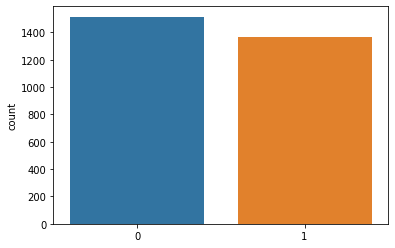

In [136]:
sns.countplot(pred)

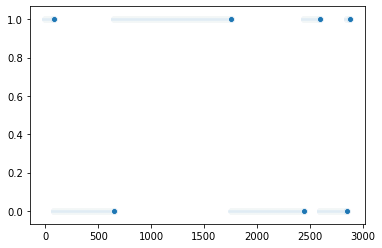

In [137]:
sns.scatterplot(np.arange(len(pred)),pred)

## Song Classification

### EDM

In [14]:
# Same as above but for classic
# Load file names
edm_filenames = os.listdir('data/midi')
if '.DS_Store' in edm_filenames:
    edm_filenames.remove('.DS_Store')

edm_filenames_clean = edm_filenames.copy()
# Remove Unnecessary Strings
for ix,file in enumerate(edm_filenames_clean):
    edm_filenames_clean[ix] = edm_filenames_clean[ix].replace('  (midi by Carlo Prato) (www.cprato.com)','')
    edm_filenames_clean[ix] = edm_filenames_clean[ix].replace(' (midi by Carlo Prato) (www.cprato.com)','')
    edm_filenames_clean[ix] = edm_filenames_clean[ix].replace('.mid','')
# Generate Pandas Dataframe with filenames and CSV version of MIDI files
music_type = []
df_edm = pd.DataFrame({'filenames':edm_filenames,'song':edm_filenames_clean})
df_edm['filenames_clean2'] = df_edm['song'].copy()
df_edm['music_type'] = df_edm['song'].copy()
df_edm['music_type'] = 'edm'
df_edm.sort_values(by=['filenames_clean2'],inplace=True)
df_edm.drop(columns=['filenames_clean2'],inplace=True)
df_edm.reset_index(drop=True,inplace=True)

In [194]:
# Instrument names for look up
melody_name = ['Bassmelody','Chords','Lead','MIDI Out','Pad','Piano','Saw Chords','Second Lead','Strings',
'Voice','Voice Synth']
bass_name = ['Basses','basses','Bass','bass']
drum_name = ['Drums','drums','Drum','drum']

# Merge all tracks and Combine all songs
melody,bass,drum = [],[],[]
song_names = []
for ix,song in enumerate(df_edm['filenames'][:]): # Switch multiple songs
    midi_loaded = pypianoroll.Multitrack('data/midi/'+song)
    
    melody_holder = np.zeros(midi_loaded.tracks[0].pianoroll.shape)
    bass_holder   = np.zeros(midi_loaded.tracks[0].pianoroll.shape)
    drum_holder   = np.zeros(midi_loaded.tracks[0].pianoroll.shape)

    for jx,track in enumerate(midi_loaded.tracks):
        if track.name in bass_name:
            bass_holder+=track.pianoroll
        elif track.name in drum_name:
            drum_holder+=track.pianoroll    
        else:
            melody_holder+=track.pianoroll
    melody.append(melody_holder[:-120])
    bass.append(bass_holder[:-120])
    drum.append(drum_holder[:-120])
    song_names+=[df_edm['song'][ix]]*len(melody_holder[:-120])

# Let first song's mean note to be note to adjust other songs to. For melody and bass only.
melody_keyss = []
for seq in melody[0]:
    melody_keyss += [ ix for (ix,x) in enumerate(seq) if x >= 10 ]
mean_note = int(np.mean(melody_keyss))

# Adjust rest of song's keys to be centered around first song's mean key. For melody and bass only.
for ix,song in enumerate(melody):
    melody_keyss = []
    for seq in song:
        melody_keyss += [ ix for (ix,x) in enumerate(seq) if x >= 10 ]
    current_song_mean_note = int(np.mean(melody_keyss))   
    melody[ix] = np.roll(melody[ix],mean_note-current_song_mean_note)
    bass[ix] = np.roll(bass[ix],mean_note-current_song_mean_note)
    
# Concat all individual files
melody_compiled,bass_compiled,drum_compiled = melody[0],bass[0],drum[0]
for i in trange(1,len(melody)):
    melody_compiled = np.concatenate((melody_compiled,melody[i]))
    bass_compiled = np.concatenate((bass_compiled,bass[i]))
    drum_compiled = np.concatenate((drum_compiled,drum[i]))

# Update blank midi file with compiled version
blank_midi = pypianoroll.Multitrack('midi/blank.mid')
blank_midi.tempo = midi_loaded.tempo/midi_loaded.tempo*120
blank_midi.tracks[0].pianoroll = melody_compiled
blank_midi.tracks.pop(1)
blank_midi.tracks.pop(1)

semitone = blank_midi.tracks[0].pianoroll
semitone_compiled = blank_midi.tracks[0].pianoroll
semitone_list = [-3,-2,-1,1,2,3]
song_names = song_names*(len(semitone_list)+1)
for i in trange(len(semitone_list)):
    semitone_compiled = np.concatenate((semitone_compiled,np.roll(semitone,semitone_list[i])))


C:\Users\matt\Anaconda3\envs\nlp\lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


In [7]:
data_edm = pd.DataFrame(semitone_compiled)
data_edm['target']=data_edm[127]
data_edm['target']=song_names
#data['target']=target_names*7
# Create rolling sum of 50 sequences
data_edm[np.arange(128)] = data_edm[np.arange(128)].rolling(50).sum()
data_edm.dropna(inplace=True)

### Classic

In [15]:
# Same as above but for classic
# Load file names
classic_filenames = os.listdir('data/midi_classic')
if '.DS_Store' in classic_filenames:
    classic_filenames.remove('.DS_Store')

classic_filenames_clean = classic_filenames.copy()
# Remove Unnecessary Strings
for ix,file in enumerate(classic_filenames_clean):
    classic_filenames_clean[ix] = classic_filenames_clean[ix].replace('  (midi by Carlo Prato) (www.cprato.com)','')
    classic_filenames_clean[ix] = classic_filenames_clean[ix].replace(' (midi by Carlo Prato) (www.cprato.com)','')
    classic_filenames_clean[ix] = classic_filenames_clean[ix].replace('.mid','')
# Generate Pandas Dataframe with filenames and CSV version of MIDI files
music_type = []
df_classic = pd.DataFrame({'filenames':classic_filenames,'song':classic_filenames_clean})
df_classic['filenames_clean2'] = df_classic['song'].copy()
df_classic['music_type'] = df_classic['song'].copy()
df_classic['music_type'] = 'edm'
df_classic.sort_values(by=['filenames_clean2'],inplace=True)
df_classic.drop(columns=['filenames_clean2'],inplace=True)
df_classic.reset_index(drop=True,inplace=True)

In [9]:
# Instrument names for look up
melody_name = ['Bassmelody','Chords','Lead','MIDI Out','Pad','Piano','Saw Chords','Second Lead','Strings',
'Voice','Voice Synth']
bass_name = ['Basses','basses','Bass','bass']
drum_name = ['Drums','drums','Drum','drum']

# Merge all tracks and Combine all songs
melody,bass,drum = [],[],[]
song_names = []
for ix,song in enumerate(df_classic['filenames'][:]): # Switch multiple songs
    midi_loaded = pypianoroll.Multitrack('data/midi_classic/'+song)
    
    melody_holder = np.zeros(midi_loaded.tracks[0].pianoroll.shape)
    bass_holder   = np.zeros(midi_loaded.tracks[0].pianoroll.shape)
    drum_holder   = np.zeros(midi_loaded.tracks[0].pianoroll.shape)

    for jx,track in enumerate(midi_loaded.tracks):
        if track.name in bass_name:
            bass_holder+=track.pianoroll
        elif track.name in drum_name:
            drum_holder+=track.pianoroll    
        else:
            melody_holder+=track.pianoroll
    melody.append(melody_holder[:-120])
    bass.append(bass_holder[:-120])
    drum.append(drum_holder[:-120])
    song_names+=[df_classic['song'][ix]]*len(melody_holder[:-120])

# Let first song's mean note to be note to adjust other songs to. For melody and bass only.
melody_keyss = []
for seq in melody[0]:
    melody_keyss += [ ix for (ix,x) in enumerate(seq) if x >= 10 ]
mean_note = int(np.mean(melody_keyss))

# Adjust rest of song's keys to be centered around first song's mean key. For melody and bass only.
for ix,song in enumerate(melody):
    melody_keyss = []
    for seq in song:
        melody_keyss += [ ix for (ix,x) in enumerate(seq) if x >= 10 ]
    current_song_mean_note = int(np.mean(melody_keyss))   
    melody[ix] = np.roll(melody[ix],mean_note-current_song_mean_note)
    bass[ix] = np.roll(bass[ix],mean_note-current_song_mean_note)
    
# Concat all individual files
melody_compiled,bass_compiled,drum_compiled = melody[0],bass[0],drum[0]
for i in trange(1,len(melody)):
    melody_compiled = np.concatenate((melody_compiled,melody[i]))
    bass_compiled = np.concatenate((bass_compiled,bass[i]))
    drum_compiled = np.concatenate((drum_compiled,drum[i]))

# Update blank midi file with compiled version
blank_midi = pypianoroll.Multitrack('midi/blank.mid')
blank_midi.tempo = midi_loaded.tempo/midi_loaded.tempo*120
blank_midi.tracks[0].pianoroll = melody_compiled
blank_midi.tracks.pop(1)
blank_midi.tracks.pop(1)

semitone = blank_midi.tracks[0].pianoroll
semitone_compiled = blank_midi.tracks[0].pianoroll
semitone_list = [-3,-2,-1,1,2,3]
song_names = song_names*(len(semitone_list)+1)
for i in trange(len(semitone_list)):
    semitone_compiled = np.concatenate((semitone_compiled,np.roll(semitone,semitone_list[i])))

C:\Users\matt\Anaconda3\envs\nlp\lib\site-packages\pypianoroll\multitrack.py:726: RuntimeWarning: divide by zero encountered in true_divide
  bpm = 60. / np.diff(beat_times_one_more)


In [10]:
data_classic = pd.DataFrame(semitone_compiled)
data_classic['target']=data_classic[127]
data_classic['target']=song_names
#data['target']=target_names*7
# Create rolling sum of 50 sequences
data_classic[np.arange(128)] = data_classic[np.arange(128)].rolling(50).sum()
data_classic.dropna(inplace=True)

### Combine EDM and Classic Data

In [15]:
# Combine EDM and Classic Dataframe's 50 rolling sum and target
data_combined = pd.concat([data_edm,data_classic],ignore_index=True)

# Define X and y data. Also one-hot-encode targets
X = data_combined[np.arange(128)]
X.columns = list(X.columns)
y = data_combined['target']
# mlb = MultiLabelBinarizer()
# y = mlb.fit_transform(y)


#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2)

In [50]:
# scoring_list = ['accuracy', 'balanced_accuracy','f1_micro','f1_macro','f1_weighted']
# hyperparameters = {'boosting_type':['gbdt'],#gbdt, gbrt, rf, random_forest, dart, goss
#                    #'model__class_weight':[],
#                    #'model__colsample_bytree':[0.33,0.66,1],
#                    #'model__importance_type':[],
#                    #'model__learning_rate':[0.01],
#                    'max_depth':[-1,3,4],
#                    'min_child_samples':[10,20,40], # Default 20
#                    #'model__min_child_weight':[0.001], # Default 0.001
#                    #'model__min_split_gain':[0], # Default 0
#                    #'model__n_estimators':[100], # Default 100
#                    #'model__n_jobs':[0], # Default 0. Num_threads
#                    #'num_leaves':[6,15,31,62], # Default 31
#                    'objective':['multiclass'],
#                    'random_state':[209],
# #                    'reg_alpha':[0,0.5,1], # Default 0
# #                    'reg_lambda':[0,0.5,1] # Default 0
#                    #'model__silent':[], # No info
#                    #'model__subsample':[1], # Default 1
#                    #'model__subsample_for_bin':[], # Default 200000
#                    #'model__subsample_freq':[0], # Default 0
                   
#                    }
# lgbm = RandomizedSearchCV(estimator=LGBMClassifier(),
#                              param_distributions=hyperparameters,
#                              cv=3,
#                              random_state=209,
#                              scoring=scoring_list[4],
#                              #n_iter=10,
#                              verbose=2)
# lgbm.fit(X_train,y_train)
# with open('lgbm.pkl', 'wb') as picklefile:
#     pickle.dump(lgbm, picklefile)
# accuracy_score(y_test, lgbm.predict(X_test.values)) 

Normalized confusion matrix


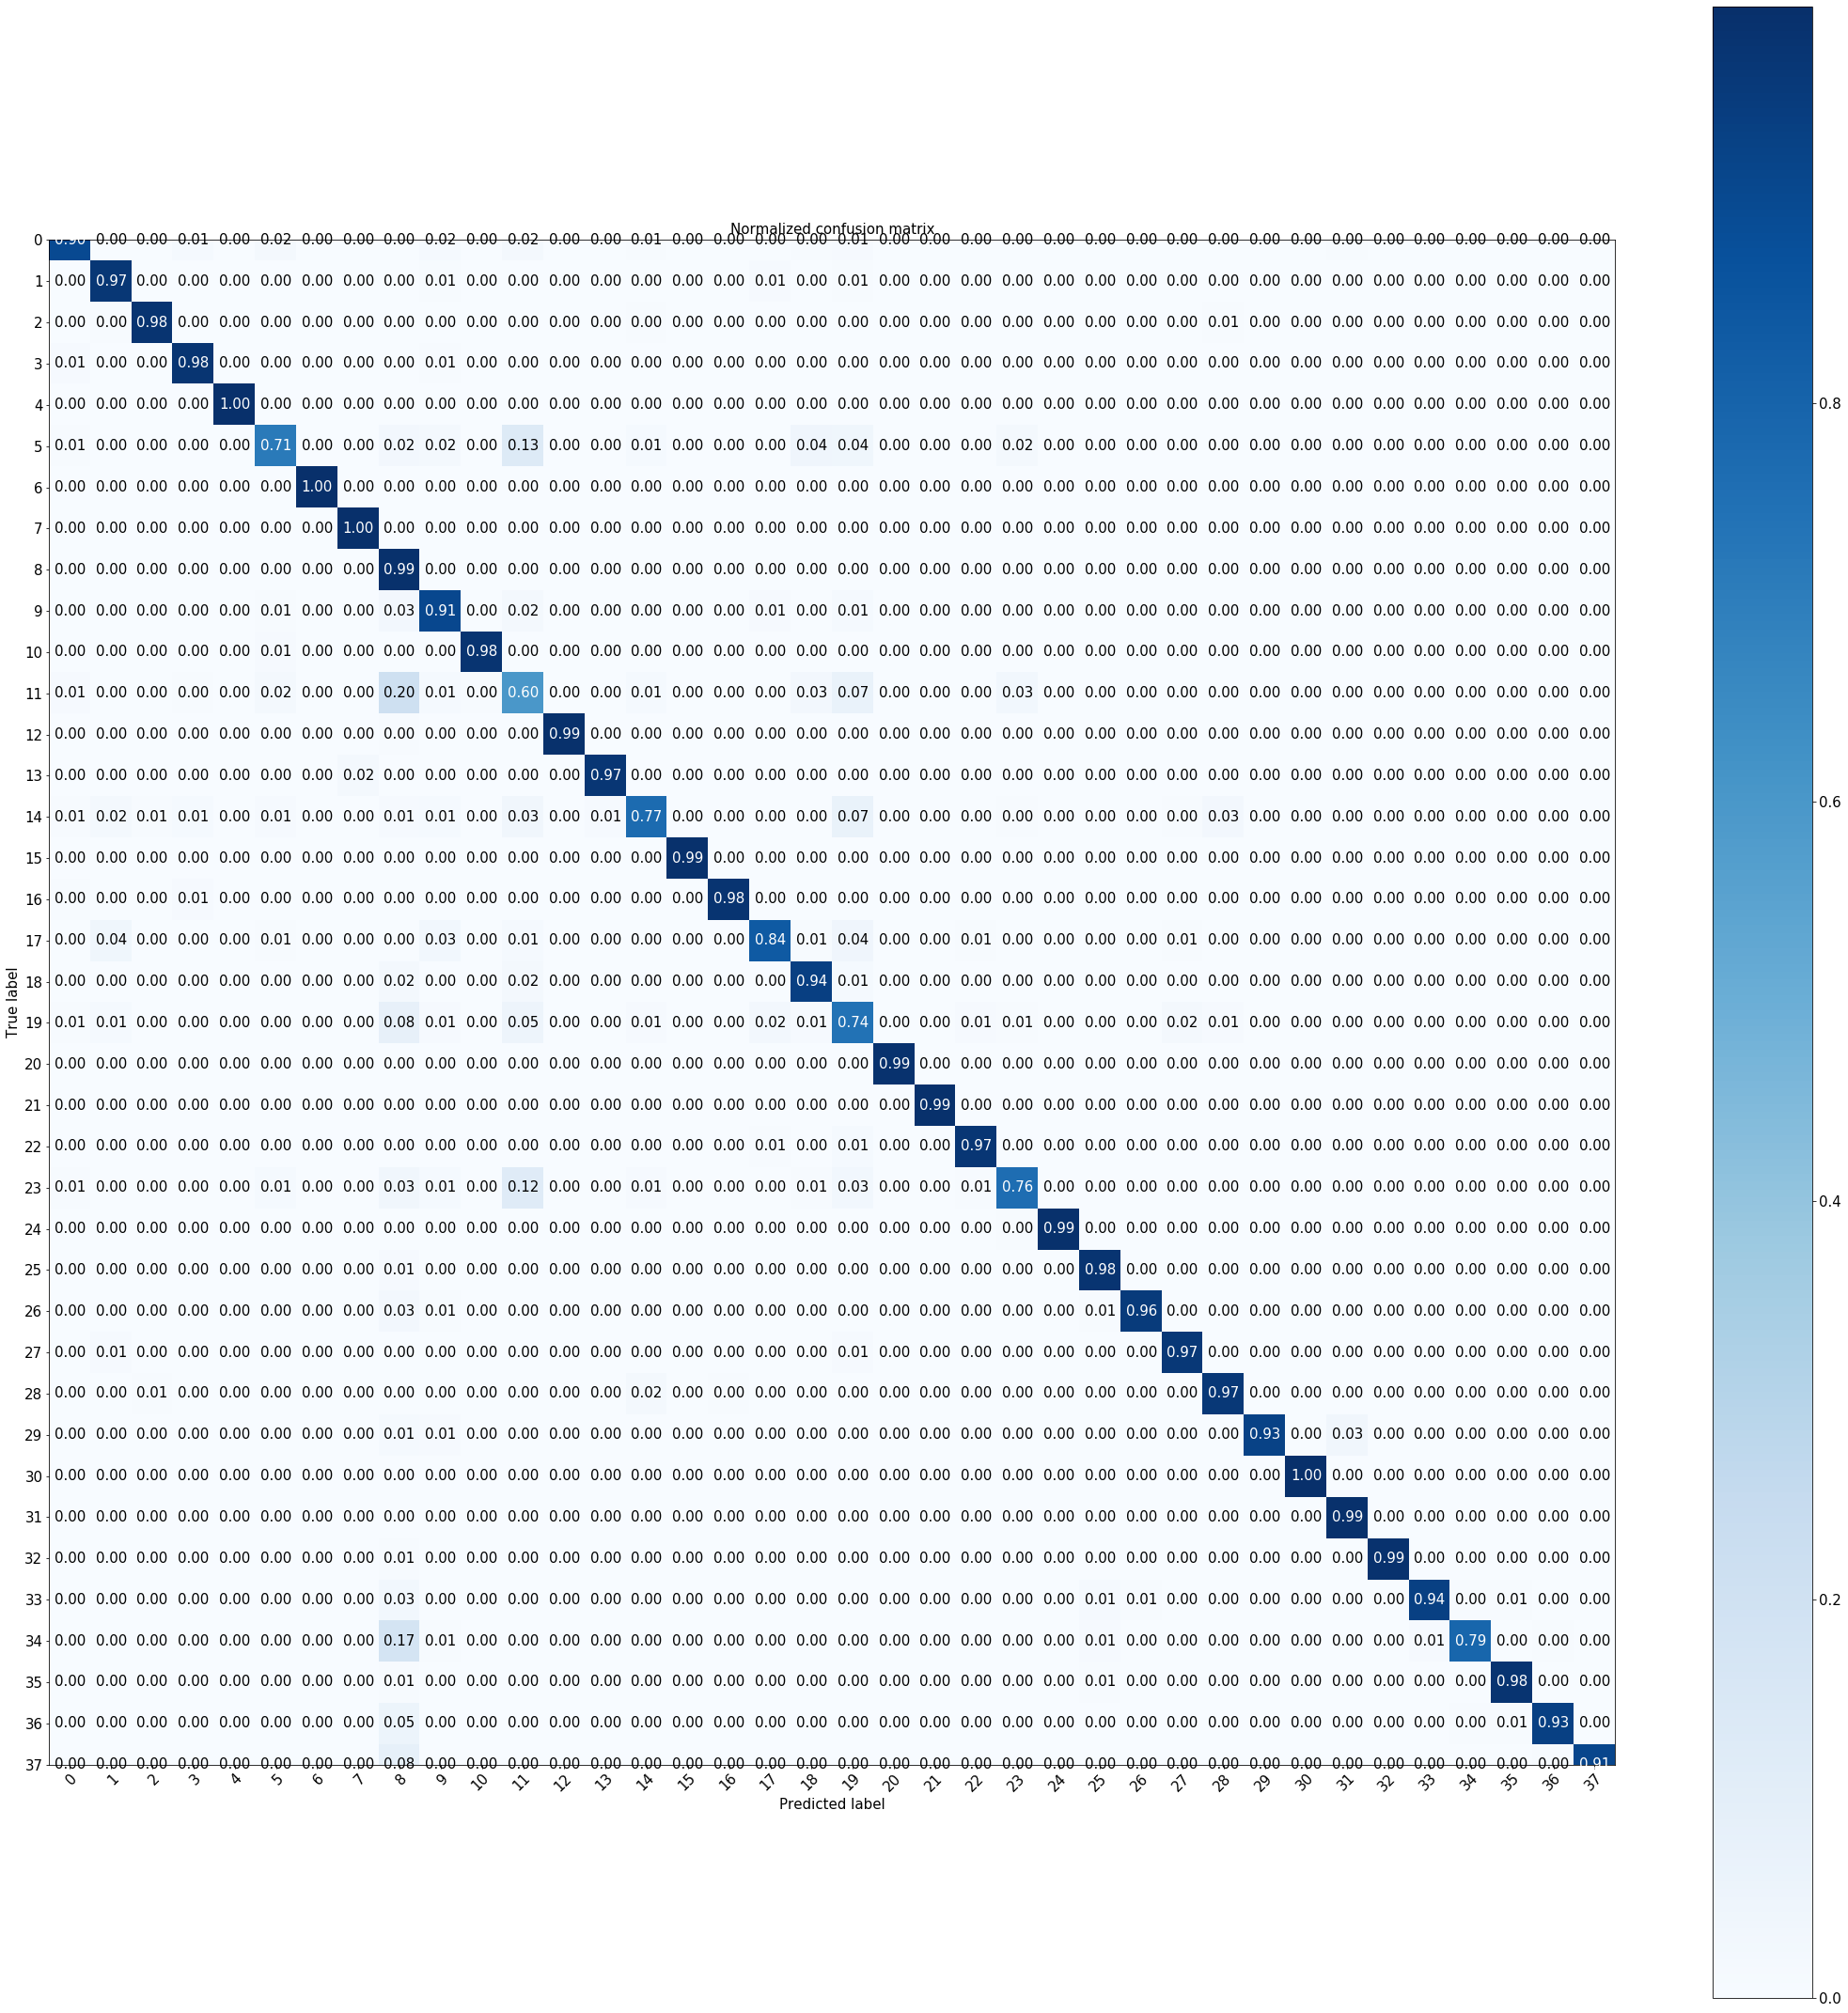

In [46]:
plot_confusion_matrix((y_test),lgbm.predict(X_test),classes=np.arange(38),normalize=True);

In [39]:
various_scores(lgbm,X_test,y_test,'Test')

Test  Data
######################################################
Accuracy : 94.65 %
______________________________________________________
                                                                         precision    recall  f1-score   support

                                                    Alan Walker - Alone       0.92      0.90      0.91      2093
                                     Alan Walker - Faded (Original Mix)       0.91      0.97      0.94      3787
                                         Alan Walker - Sing Me To Sleep       0.98      0.98      0.98      2252
                                                  Calvin Harris - Blame       0.95      0.98      0.96      2214
                                                 Calvin Harris - My Way       1.00      1.00      1.00      2178
                                                  Galantis - Love On Me       0.85      0.71      0.78      2109
                                                    Galantis - No Mo

### Perform Classification

In [53]:
lgbm = pickle.load( open('lgbm.pkl', "rb" ) )
blank_midi =  pypianoroll.Multitrack('midi/success1.mid')
test_data = pd.DataFrame(blank_midi.tracks[0].pianoroll)
test_data = test_data.rolling(50).sum()
test_data.dropna(inplace=True)
pred = lgbm.predict(test_data.values)
play_music('midi/success1.mid') 

Music file midi/success1.mid loaded!


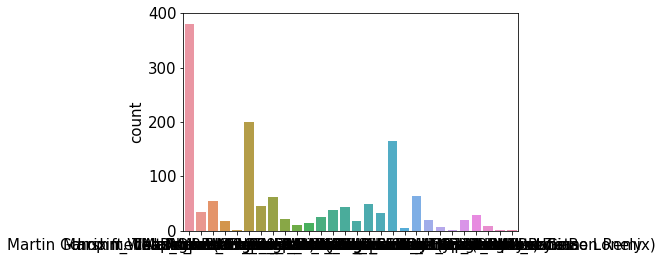

In [54]:
sns.countplot(pred)

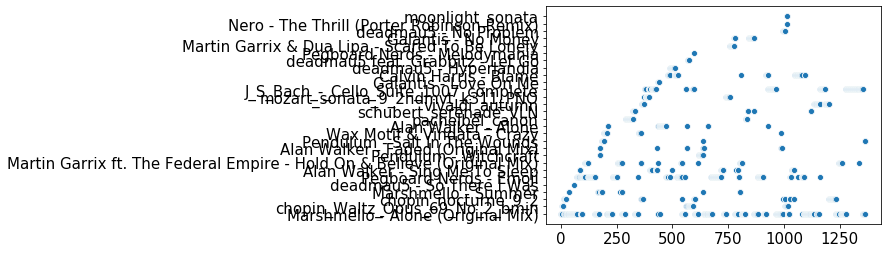

In [55]:
sns.scatterplot(np.arange(len(pred)),pred)

## NN Classifier

In [77]:
# Load saved notes for both EDM and Classic
notes_edm = pickle.load( open( "midi/classifier/notes_edm.pkl", "rb" ) )
notes_classic = pickle.load( open( "midi/classifier/notes_classic.pkl", "rb" ) )
notes_combined = notes_edm+notes_classic
# Convert notes to int
n_vocab = len(list(set(notes_combined)))
# get all pitch names
pitchnames = sorted(set(item for item in notes_combined))
# create a dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
# Convert notes to int
ints_edm = []
for i in range(len(notes_edm)):
    ints_edm.append(note_to_int[notes_edm[i]])
ints_classic = []
for i in range(len(notes_classic)):
    ints_classic.append(note_to_int[notes_classic[i]])
# Prepare input data for model training
X = []
y = []
sequence_length = 10
for i in range(len(ints_edm)-sequence_length):
    X.append(ints_edm[i:i+sequence_length])
    y.append('EDM')
for i in range(len(ints_classic)-sequence_length):
    X.append(ints_classic[i:i+sequence_length])
    y.append('Classic')  
X = np.array(X)
y = np.array(y)
# create scaler
scaler = StandardScaler()
# fit scaler on data
scaler.fit(X)
# apply transform
X_std = scaler.transform(X)

encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
# create model
classify_model = Sequential()
classify_model.add(Dense(32, input_dim=X.shape[1], activation='relu'))
classify_model.add(Dense(16,  activation='relu'))
classify_model.add(Dense(1, activation='sigmoid'))
# Compile model
classify_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# # Train
#model.fit(X_std, encoded_y, epochs=4000, batch_size=1024, verbose=2)
classify_model = pickle.load( open('nn_classifier.pkl', "rb" ) )

In [ ]:
#filename = 'midi/success2.mid'
filename = 'data/midi/'+df_edm['filenames'][0]
#filename = 'data/midi_classic/'+df_classic['filenames'][9]
# Take out drum and only leave melody
blank_midi =  pypianoroll.Multitrack('midi/blank.mid')
test_midi =  pypianoroll.Multitrack(filename)
blank_midi.tracks[0].pianoroll = test_midi.tracks[0].pianoroll
blank_midi.tracks.pop(1)
blank_midi.tracks.pop(1)
pypianoroll.write(blank_midi,'midi/classify.mid')
# Melody Portion
notes_classify = []
for file in glob.glob('midi/classify.mid'):
    midi = converter.parse(file)
    notes_to_parse = None
    parts = instrument.partitionByInstrument(midi)
    if parts: # file has instrument parts
        notes_to_parse = parts.parts[0].recurse()
    else: # file has notes_classify in a flat structure
        notes_to_parse = midi.flat.notes_classify
    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes_classify.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            notes_classify.append('.'.join(str(n) for n in element.normalOrder))
# Convert notes to int
ints_classify = []
for i in range(len(notes_classify)):
    ints_classify.append(note_to_int[notes_classify[i]])
# Prepare input data for model training
X = []
for i in range(len(ints_classify)-sequence_length):
    X.append(ints_classify[i:i+sequence_length])
pred = model.predict(scaler.transform(X))
pred_label = []
for label in pred:
    pred_label+=list(label)
pred_label = ['EDM' if x>0.4 else 'Classic' for x in pred_label]

/Users/matthewlee/anaconda3/envs/nlp/lib/python3.6/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


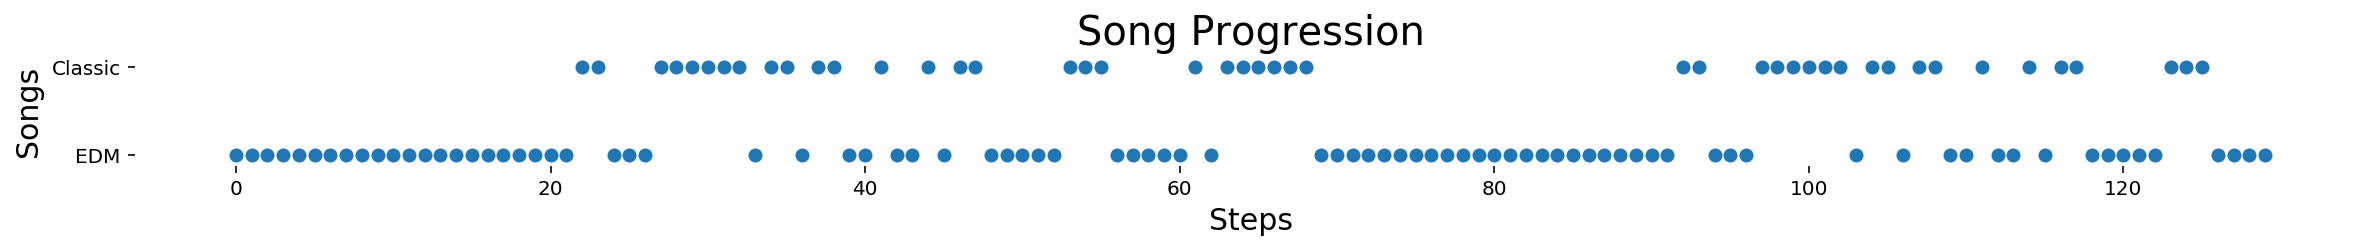

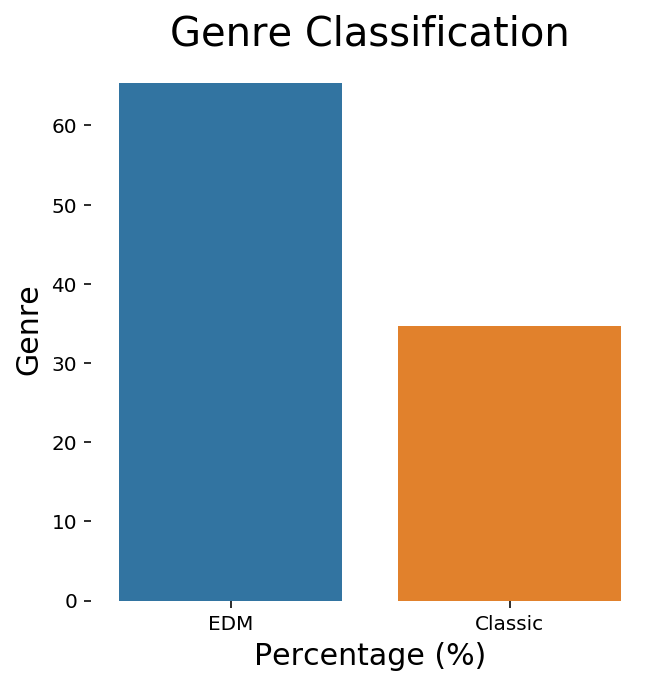

In [35]:
plot_genre_progression(pred_label)
plot_genre_composition(pred_label)